# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
!nvcc --version

/bin/bash: nvcc: command not found


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [4]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
import cupy as cp

In [5]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [6]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import seaborn as sns
# import colorsys

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [9]:
FONTSIZE = 20

In [10]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [11]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [12]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    """
    result = array.copy()
    result[mask] = value
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [14]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [15]:
zscore_threshold = 4
VOLTAGE_SCALING_VALUE = 0.195

In [16]:
BAND_TO_FREQ = {"theta": (4,12), "gamma": (30,51)}

In [91]:
FILTER_BAND = (0, 56)

In [89]:
"filter_band".upper()

'FILTER_BAND'

In [17]:
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [18]:
LFP_TRACES_DF = pd.read_pickle("./proc/{}_01_lfp_traces_and_frames.pkl".format(OUTPUT_PREFIX))

In [19]:
LFP_TRACES_DF.shape

(28, 24)

## Preprocessing

In [20]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [21]:
original_trace_columns

['vHPC_lfp_trace',
 'BLA_lfp_trace',
 'LH_lfp_trace',
 'MD_lfp_trace',
 'mPFC_lfp_trace']

In [22]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [23]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps,vHPC_lfp_trace,BLA_lfp_trace,LH_lfp_trace,MD_lfp_trace,mPFC_lfp_trace
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[65.715, 96.329994, 95.159996, 77.61, 112.905,...","[112.515, 143.715, 128.31, 74.49, 67.274994, 3...","[114.465, 145.665, 125.384995, 62.204998, 64.7...","[148.59, 188.95499, 183.495, 133.185, 144.105,...","[72.735, 125.189995, 118.56, 86.774994, 139.62..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[65.715, 96.329994, 95.159996, 77.61, 112.905,...","[112.515, 143.715, 128.31, 74.49, 67.274994, 3...","[114.465, 145.665, 125.384995, 62.204998, 64.7...","[148.59, 188.95499, 183.495, 133.185, 144.105,...","[72.735, 125.189995, 118.56, 86.774994, 139.62..."
2,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-100.619995, -102.96, -129.87, -165.75, -191....","[-42.899998, -26.324999, -21.84, -31.98, -28.4...","[-44.85, -31.589998, -30.224998, -51.285, -62....","[-27.884998, -17.55, -9.554999, -11.115, -10.7...","[-38.805, -20.085, 2.73, 11.309999, 28.47, 64...."
3,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-100.619995, -102.96, -129.87, -165.75, -191....","[-42.899998, -26.324999, -21.84, -31.98, -28.4...","[-44.85, -31.589998, -30.224998, -51.285, -62....","[-27.884998, -17.55, -9.554999, -11.115, -10.7...","[-38.805, -20.085, 2.73, 11.309999, 28.47, 64...."
4,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...",

# Calculating modified zscore

`0.6745(xi – x̃) / MAD`

In [24]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_MAD".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.median_abs_deviation(x))

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [25]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_modified_zscore".format(brain_region)
    MAD_column = "{}_lfp_MAD".format(brain_region)

    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: 0.6745 * (x[col] - np.median(x[col])) / x[MAD_column], axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [26]:
LFP_TRACES_DF[updated_column]

0     [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
1     [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
2     [-0.2906841, -0.15521966, 0.009877616, 0.07196...
3     [-0.2906841, -0.15521966, 0.009877616, 0.07196...
4     [0.024630615, -0.43766713, -0.66123736, -0.689...
5     [0.024630615, -0.43766713, -0.66123736, -0.689...
6     [0.14578532, 0.297402, -0.1399539, -0.56370324...
7     [0.14578532, 0.297402, -0.1399539, -0.56370324...
8     [-0.3882878, 0.09206825, 0.15211275, -0.506375...
9     [-0.3882878, 0.09206825, 0.15211275, -0.506375...
10    [-0.5509115, -0.8881615, 0.029326085, 0.804372...
11    [-0.5509115, -0.8881615, 0.029326085, 0.804372...
12    [-0.6099, -0.80939996, -0.6707, -0.39139998, -...
13    [-0.6099, -0.80939996, -0.6707, -0.39139998, -...
14    [-0.60751194, -0.5821027, -0.3257003, -0.02078...
15    [-0.60751194, -0.5821027, -0.3257003, -0.02078...
16    [-1.3656029, -1.3822061, -0.97958153, -0.36526...
17    [-1.3656029, -1.3822061, -0.97958153, -0.3

## calculating root mean sequare

In [27]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))


vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [28]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,vHPC_lfp_modified_zscore,BLA_lfp_modified_zscore,LH_lfp_modified_zscore,MD_lfp_modified_zscore,mPFC_lfp_modified_zscore,vHPC_lfp_RMS,BLA_lfp_RMS,LH_lfp_RMS,MD_lfp_RMS,mPFC_lfp_RMS
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.3072605, 0.47246566, 0.4661521, 0.37144852,...","[1.2434074, 1.5881996, 1.4179585, 0.8231917, 0...","[1.9996542, 2.5447047, 2.1904216, 1.0866945, 1...","[2.124255, 2.7035973, 2.6252322, 1.9031534, 2....","[0.74413866, 1.2793614, 1.2117124, 0.88739526,...","[0.34131178, 0.50032055, 0.49424377, 0.4030922...","[1.1980088, 1.5302123, 1.3661867, 0.79313576, ...","[1.8708509, 2.380793, 2.0493307, 1.0166975, 1....","[2.0567217, 2.6154373, 2.5398624, 1.843492, 1....","[0.7264124, 1.2502861, 1.1840717, 0.8666313, 1..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.3072605, 0.47246566, 0.4661521, 0.37144852,...","[1.2434074, 1.5881996, 1.4179585, 0.8231917, 0...","[1.9996542, 2.5447047, 2.1904216, 1.0866945, 1...","[2.124255, 2.7035973, 2.6252322, 1.9031534, 2....","[0.74413866, 1.2793614, 1.2117124, 0.88739526,...","[0.34131178, 0.50032055, 0.49424377, 0.4030922...","[1.1980088, 1.5302123, 1.3661867, 0.79313576, ...","[1.8708509, 2.380793, 2.0493307, 1.0166975, 1....","[2.0567217, 2.6154373, 2.5398624, 1.843492, 1....","[0.7264124, 1.2502861, 1.1840717, 0.8666313, 1..."
2,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.63018984, -0.6449599, -0.8148157, -1.04129...","[-0.34401006, -0.21632071, -0.18176949, -0.259...","[-0.35874507, -0.25794065, -0.24756375, -0.407...","[-0.26534897, -0.17461675, -0.104427665, -0.11...","[-0.2906841, -0.15521966, 0.009877616, 0.07196...","[-0.46290472, -0.47366998, -0.59747005, -0.762...","[-0.23170301, -0.1421814, -0.117957905, -0.172...","[-0.19903451, -0.14018953, -0.13413195, -0.227...","[-0.15576158, -0.09803177, -0.053372853, -0.06...","[-0.20107095, -0.10407189, 0.014145696, 0.0586..."
3,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.63018984, -0.6449599, -0.8148157, -1.04129...","[-0.34401006, -0.21632071, -0.18176949, -0.259...","[-0.35874507, -0.25794065, -0.24756375, -0.407...","[-0.26534897, -0.17461675, -0.104427665, -0.11...","[-0.2906841, -0.15521966, 0.009877616, 0.07196...","[-0.46290472, -0.47366998, -0.59747005, -0.762...","[-0.23170301, -0.1421814, -0.117957905, -0.172...","[-0.19903451, -0.14018953, -0.13413195, -0.227...","[-0.15576158, -0.09803177, -0.053372853, -0.06...","[-0.20107095, -0.10407189, 0.014145696, 0.0586..."
4,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 

## Filtering for zscore value

In [29]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [30]:
zscore_columns

['vHPC_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'mPFC_lfp_modified_zscore']

In [31]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

vHPC_lfp_modified_zscore
BLA_lfp_modified_zscore
LH_lfp_modified_zscore
MD_lfp_modified_zscore
mPFC_lfp_modified_zscore


In [32]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: mPFC_lfp_mask, dtype: object

In [33]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(3179713,)

In [34]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

930

- Filtering raw traces by zscore

In [35]:
LFP_TRACES_DF[col].head()

0    [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
1    [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
2    [-0.2906841, -0.15521966, 0.009877616, 0.07196...
3    [-0.2906841, -0.15521966, 0.009877616, 0.07196...
4    [0.024630615, -0.43766713, -0.66123736, -0.689...
Name: mPFC_lfp_modified_zscore, dtype: object

In [36]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [37]:
LFP_TRACES_DF[col].head()

0    [72.735, 125.189995, 118.56, 86.774994, 139.62...
1    [72.735, 125.189995, 118.56, 86.774994, 139.62...
2    [-38.805, -20.085, 2.73, 11.309999, 28.47, 64....
3    [-38.805, -20.085, 2.73, 11.309999, 28.47, 64....
4    [0.78, -46.8, -69.81, -72.735, -126.74999, -16...
Name: mPFC_lfp_trace, dtype: object

In [38]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

0

- Calculating RMS of filtered signal

In [39]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [40]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

vHPC_lfp_trace_filtered
BLA_lfp_trace_filtered
LH_lfp_trace_filtered
MD_lfp_trace_filtered
mPFC_lfp_trace_filtered


# Power Calcuation

- Getting the column name of all the traces

In [41]:
input_columns = [col for col in LFP_TRACES_DF.columns if "RMS" in col and "filtered" in col]

In [42]:
input_columns

['vHPC_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'mPFC_lfp_RMS_filtered']

In [43]:
for col in input_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: np.round(x.astype(np.float32), decimals=3))

vHPC_lfp_RMS_filtered
BLA_lfp_RMS_filtered
LH_lfp_RMS_filtered
MD_lfp_RMS_filtered
mPFC_lfp_RMS_filtered


- Calcuating the power at each frequency band

In [44]:
LFP_TRACES_DF[col].iloc[0]

array([ 0.736,  1.267,  1.2  , ..., -0.442, -0.489, -0.29 ], dtype=float32)

In [102]:
for col in input_columns:
    # brain_region = col.split("_")[0]
    brain_region = col.replace("_lfp", "").replace("RMS_filtered", "").strip("_")
    print(brain_region)

    try:
        # Define column names
        frequencies_col = f"{brain_region}_power_frequencies"
        power_col = f"{brain_region}_power_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_power = {}

        # Apply Multitaper function to the lfp_trace column
        for index, row in LFP_TRACES_DF.iterrows():
            print(index)
            index_to_multitaper[index] = Multitaper(
                    time_series=row[col], 
                    sampling_frequency=RESAMPLE_RATE, 
                    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                    time_window_duration=TIME_WINDOW_DURATION, 
                    time_window_step=TIME_WINDOW_STEP
                )
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_power[index] = index_to_connectivity[index].power().squeeze()[:, FILTER_BAND[0]: FILTER_BAND[1]]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF.index.to_series().map(index_to_power)
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float32))
    
    except Exception as e: 
        print(e)
        

vHPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
BLA
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
LH
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
MD
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
mPFC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [100]:
# for col in input_columns:
#     # brain_region = col.split("_")[0]
#     brain_region = col.replace("_lfp", "")
#     print(brain_region)

#     # Define column names
#     multitaper_col = f"{brain_region}_power_multitaper"
#     connectivity_col = f"{brain_region}_power_connectivity"
#     frequencies_col = f"{brain_region}_power_frequencies"
#     power_col = f"{brain_region}_power_all_frequencies_all_windows"
    
#     try:
#         # Apply Multitaper function to the lfp_trace column
#         LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF[col].apply(
#             lambda x: Multitaper(
#                 time_series=x, 
#                 sampling_frequency=RESAMPLE_RATE, 
#                 time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
#                 time_window_duration=TIME_WINDOW_DURATION, 
#                 time_window_step=TIME_WINDOW_STEP
#             )
#         )

#         # Apply Connectivity function to the multitaper column
#         LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
#             lambda x: Connectivity.from_multitaper(x)
#         )

#         # Apply frequencies and power functions to the connectivity column
#         LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
#             lambda x: x.frequencies
#         )
#         LFP_TRACES_DF[power_col] = LFP_TRACES_DF[connectivity_col].apply(
#             lambda x: x.power().squeeze()
#         )
        
#         LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float32))
            
#         # Removing unnecessary columns
#         LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
    
#     except Exception as e: 
#         print(e)

vHPC
0
'Series' object has no attribute 'fft'
BLA
0
'Series' object has no attribute 'fft'
LH
0
'Series' object has no attribute 'fft'
MD
0
'Series' object has no attribute 'fft'
mPFC
0
'Series' object has no attribute 'fft'


In [ ]:
for col in all_frequencies_columns:
    if "power" in col:
        LFP_TRACES_DF[col] = LFP_TRACES_DF.apply(lambda x: x[col][:, (x["power_calculation_frequencies"] >= FILTER_BAND[0]) & (x["power_calculation_frequencies"] < FILTER_BAND[1])], axis=1)
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF["power_calculation_frequencies"].apply(lambda x: x[FILTER_BAND[0]: FILTER_BAND[1]])


- Getting the timestamps of the power

In [46]:
LFP_TRACES_DF["power_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])
# .iloc[0][500:-500:500].shape

- Making sure that the timestamps for power makes sense with shape and values

In [47]:
LFP_TRACES_DF["power_timestamps"].head().apply(lambda x: x.shape)

0    (6358,)
1    (6358,)
2    (6358,)
3    (6358,)
4    (6437,)
Name: power_timestamps, dtype: object

In [48]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col][0]].iloc[0].shape

(6358, 500)

In [49]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 63594200, 63594220, 63594240])

In [50]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 63560000, 63570000, 63580000])

- Checking if the right frequencies are being used

In [51]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col]].head()

,vHPC_RMS_filtered_power_frequencies,BLA_RMS_filtered_power_frequencies,LH_RMS_filtered_power_frequencies,MD_RMS_filtered_power_frequencies,mPFC_RMS_filtered_power_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [52]:
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [53]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col], errors="ignore")

In [54]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,LH_lfp_RMS_filtered,MD_lfp_RMS_filtered,mPFC_lfp_RMS_filtered,vHPC_RMS_filtered_power_all_frequencies_all_windows,BLA_RMS_filtered_power_all_frequencies_all_windows,LH_RMS_filtered_power_all_frequencies_all_windows,MD_RMS_filtered_power_all_frequencies_all_windows,mPFC_RMS_filtered_power_all_frequencies_all_windows,power_timestamps,power_calculation_frequencies
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1.954, 2.486, 2.14, 1.062, 1.105, 1.118, 0.94...","[2.12, 2.695, 2.617, 1.9, 2.056, 2.075, 1.839,...","[0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.013653977, 0.016593909, 0.0148355495, 0.00...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.016564792, 0.027819308, 0.03145214, 0.0273...","[[0.016539268, 0.01998677, 0.017368766, 0.0058...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1.954, 2.486, 2.14, 1.062, 1.105, 1.118, 0.94...","[2.12, 2.695, 2.617, 1.9, 2.056, 2.075, 1.839,...","[0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.013653977, 0.016593909, 0.0148355495, 0.00...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.016564792, 0.027819308, 0.03145214, 0.0273...","[[0.016539268, 0.01998677, 0.017368766, 0.0058...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.304, -0.214, -0.205, -0.348, -0.424, -0.38...","[-0.213, -0.134, -0.073, -0.085, -0.082, -0.14...","[-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...","[[0.001042456, 0.009847558, 0.012313993, 0.009...","[[0.0019507094, 0.021079458, 0.020683793, 0.01...","[[0.0033906468, 0.026863998, 0.024397772, 0.02...","[[0.0064097624, 0.025944894, 0.023217766, 0.01...","[[0.0026253168, 0.023724452, 0.023461273, 0.01...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.304, -0.214, -0.205, -0.348, -0.424, -0.38...","[-0.213, -0.134, -0.073, -0.085, -0.082, -0.14...","[-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...","[[0.001042456, 0.009847558, 0.012313993, 0.009...","[[0.0019507094, 0.021079458, 0.020683793, 0.01...","[[0.0033906468, 0.026863998, 0.024397772, 0.02...","[[0.0064097624, 0.025944894, 0.023217766, 0.01...","[[0.0026253168, 0.023724452, 0.023461273, 0.01...","[10000, 20000, 30000, 4

In [55]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].head()

0    [[0.016539268, 0.01998677, 0.017368766, 0.0058...
1    [[0.016539268, 0.01998677, 0.017368766, 0.0058...
2    [[0.0026253168, 0.023724452, 0.023461273, 0.01...
3    [[0.0026253168, 0.023724452, 0.023461273, 0.01...
4    [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
Name: mPFC_RMS_filtered_power_all_frequencies_all_windows, dtype: object

In [56]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].iloc[4].shape

(6437, 500)

In [57]:
LFP_TRACES_DF["mPFC_lfp_RMS_filtered"].head()

0    [0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...
1    [0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...
2    [-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...
3    [-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...
4    [0.008, -0.452, -0.674, -0.703, -1.224, -1.56,...
Name: mPFC_lfp_RMS_filtered, dtype: object

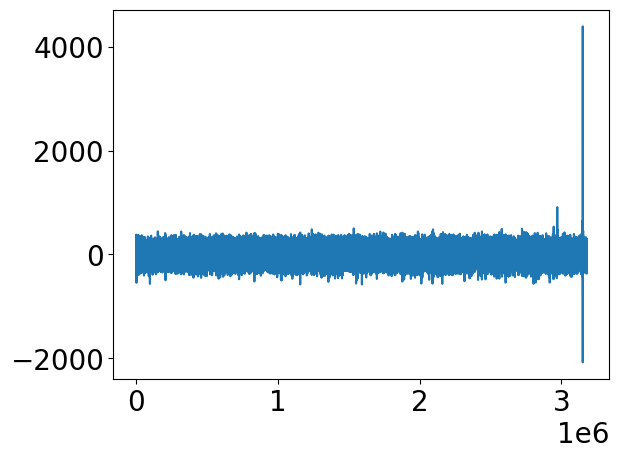

In [58]:
plt.plot(LFP_TRACES_DF["BLA_lfp_trace"].iloc[0])

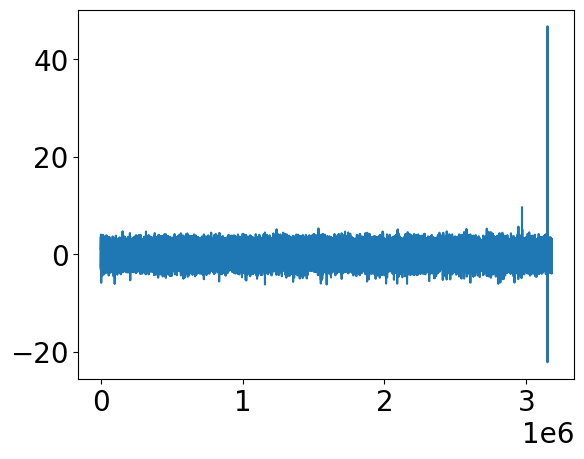

In [59]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS"].iloc[0])

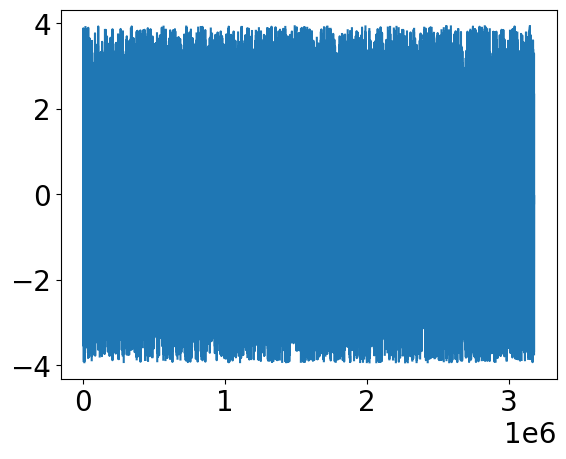

In [60]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS_filtered"].iloc[0])

## Calculating phase of signals

In [61]:
from scipy.signal import butter, filtfilt, hilbert

- Filtering for theta and gamma

In [62]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [63]:
fs = 1000
order=4

In [64]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [65]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


In [66]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [67]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


- Calculating the phase

In [68]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [69]:
band_columns

['vHPC_theta_band',
 'BLA_theta_band',
 'LH_theta_band',
 'MD_theta_band',
 'mPFC_theta_band',
 'vHPC_gamma_band',
 'BLA_gamma_band',
 'LH_gamma_band',
 'MD_gamma_band',
 'mPFC_gamma_band']

In [70]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

vHPC_theta_band
vHPC_theta_phase
BLA_theta_band
BLA_theta_phase
LH_theta_band
LH_theta_phase
MD_theta_band
MD_theta_phase
mPFC_theta_band
mPFC_theta_phase
vHPC_gamma_band
vHPC_gamma_phase
BLA_gamma_band
BLA_gamma_phase
LH_gamma_band
LH_gamma_phase
MD_gamma_band
MD_gamma_phase
mPFC_gamma_band
mPFC_gamma_phase


In [71]:
LFP_TRACES_DF[col]

0     [-0.073652945, -0.027648753, 0.023473203, 0.07...
1     [-0.073652945, -0.027648753, 0.023473203, 0.07...
2     [-0.10603527, -0.11340957, -0.11593773, -0.113...
3     [-0.10603527, -0.11340957, -0.11593773, -0.113...
4     [-0.060700476, -0.11583101, -0.16058828, -0.19...
5     [-0.060700476, -0.11583101, -0.16058828, -0.19...
6     [0.10086174, 0.10749034, 0.10687582, 0.0987401...
7     [0.10086174, 0.10749034, 0.10687582, 0.0987401...
8     [0.0702091, 0.05466633, 0.03668893, 0.01727806...
9     [0.0702091, 0.05466633, 0.03668893, 0.01727806...
10    [-0.35048875, -0.32354048, -0.27675727, -0.212...
11    [-0.35048875, -0.32354048, -0.27675727, -0.212...
12    [-0.1007646, -0.08146265, -0.05295461, -0.0165...
13    [-0.1007646, -0.08146265, -0.05295461, -0.0165...
14    [-0.1857664, -0.120168306, -0.04169256, 0.0444...
15    [-0.1857664, -0.120168306, -0.04169256, 0.0444...
16    [-0.25569814, -0.21503006, -0.15813461, -0.088...
17    [-0.25569814, -0.21503006, -0.15813461, -0

## Coherence Calculation

- Getting the trace column pairs

In [72]:
brain_region_pairs = generate_pairs(sorted(input_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [73]:
brain_region_pairs

[('BLA_lfp_RMS_filtered', 'LH_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('mPFC_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered')]

## Coherece Calculation

- Calculating the coherence

In [97]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_coherence = {}

        for index, row in LFP_TRACES_DF.iterrows():
            index_to_multitaper[index] = Multitaper(
                time_series=np.array([row[region_1], row[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            )
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_coherence[index] = index_to_connectivity[index].coherence_magnitude()[:, FILTER_BAND[0]: FILTER_BAND[1], 0, 1]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF.index.to_series().map(index_to_coherence)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

    except Exception as e: 
        print(e)

BLA_LH
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [99]:
LFP_TRACES_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0].shape

(6358, 56)

In [96]:
LFP_TRACES_DF["BLA_LH_coherence_frequencies"].iloc[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55.])

In [75]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,LH_mPFC_coherence_frequencies,LH_mPFC_coherence_all_frequencies_all_windows,LH_vHPC_coherence_frequencies,LH_vHPC_coherence_all_frequencies_all_windows,MD_mPFC_coherence_frequencies,MD_mPFC_coherence_all_frequencies_all_windows,MD_vHPC_coherence_frequencies,MD_vHPC_coherence_all_frequencies_all_windows,mPFC_vHPC_coherence_frequencies,mPFC_vHPC_coherence_all_frequencies_all_windows
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.63400275, 0.28502315, 0.45784405, 0.767824...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.63400275, 0.28502315, 0.45784405, 0.767824...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.86303043, 0.990537, 0.96561474, 0.90609324...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.33992842, 0.96113396, 0.7880446, 0.7943647...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.7520822, 0.9644764, 0.877207, 0.83641744, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.19531018, 0.9076741, 0.62200993, 0.6701233...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.687659, 0.9837023, 0.9055975, 0.89568114, ..."
3,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.86303043, 0.990537, 0.96561474, 0.90609324...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.33992842, 0.96113396, 0.7880446, 0.7943647...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.7520822, 0.9644764, 0.877207, 0.83641744, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[0.19531018, 0.9076741, 0.62200993, 0.6701233...","[0.

- Getting the timestamps of the coherence

In [76]:
LFP_TRACES_DF["coherence_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for coherence makes sense with shape and values

In [77]:
LFP_TRACES_DF["coherence_timestamps"].head().apply(lambda x: x.shape)

0    (6358,)
1    (6358,)
2    (6358,)
3    (6358,)
4    (6437,)
Name: coherence_timestamps, dtype: object

In [78]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col][0]].iloc[0].shape

(6358, 500)

In [79]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 63594200, 63594220, 63594240])

In [80]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 63560000, 63570000, 63580000])

- Checking if the right frequencies are being used

In [81]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col]].head()

,BLA_LH_coherence_frequencies,BLA_MD_coherence_frequencies,BLA_mPFC_coherence_frequencies,BLA_vHPC_coherence_frequencies,LH_MD_coherence_frequencies,LH_mPFC_coherence_frequencies,LH_vHPC_coherence_frequencies,MD_mPFC_coherence_frequencies,MD_vHPC_coherence_frequencies,mPFC_vHPC_coherence_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [82]:
LFP_TRACES_DF["coherence_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [83]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col], errors="ignore")

In [84]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,BLA_mPFC_coherence_all_frequencies_all_windows,BLA_vHPC_coherence_all_frequencies_all_windows,LH_MD_coherence_all_frequencies_all_windows,LH_mPFC_coherence_all_frequencies_all_windows,LH_vHPC_coherence_all_frequencies_all_windows,MD_mPFC_coherence_all_frequencies_all_windows,MD_vHPC_coherence_all_frequencies_all_windows,mPFC_vHPC_coherence_all_frequencies_all_windows,coherence_timestamps,coherence_calculation_frequencies
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[[0.74390054, 0.50665, 0.55825204, 0.70587826,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.63400275, 0.28502315, 0.45784405, 0.767824...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[[0.74390054, 0.50665, 0.55825204, 0.70587826,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.63400275, 0.28502315, 0.45784405, 0.767824...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[[0.75024354, 0.9798267, 0.9791971, 0.9469553,...","[[0.20768398, 0.95451677, 0.8819608, 0.9107615...","[[0.9579088, 0.98663074, 0.95743173, 0.9738688...","[[0.86303043, 0.990537, 0.96561474, 0.90609324...","[[0.33992842, 0.96113396, 0.7880446, 0.7943647...","[[0.7520822, 0.9644764, 0.877207, 0.83641744, ...","[[0.19531018, 0.9076741, 0.62200993, 0.6701233...","[[0.687659, 0.9837023, 0.9055975, 0.89568114, ...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[[0.75024354, 0.9798267, 0.9791971, 0.9469553,...","[[0.20768398, 0.95451677, 0.8819608, 0.9107615...","[[0.9579088, 0.98663074, 0.95743173, 0.9738688...","[[0.86303043, 0.990537, 0.96561474, 0.90609324...","[[0.33992842, 0.96113396, 0.7880446, 0.7943647...","[[0.7520822, 0.9644764, 0.877207, 0.83641744, ...","[[0.19531018, 0.9076741, 0.62200993, 0.6701233...","[[0.687659, 0.

In [85]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

# Calculate Granger's

In [86]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    region_1_base_name = region_1.split('_')[0]
    region_2_base_name = region_2.split('_')[0]

    pair_base_name = f"{region_1_base_name}_{region_2_base_name}"
    print(pair_base_name)

    try:
        # Define column names
        frequencies_col = f"{pair_base_name}_granger_frequencies"
        granger_1_2_col = f"{region_1_base_name}_{region_2_base_name}_granger_all_frequencies_all_windows"
        granger_2_1_col = f"{region_2_base_name}_{region_1_base_name}_granger_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_granger_1_to_2 = {}
        index_to_granger_2_to_1 = {}

        
        for index, row in LFP_TRACES_DF.iterrows():
            # Apply Multitaper function
            index_to_multitaper[index] = Multitaper(
                    time_series=np.array([row[region_1], row[region_2]]).T, 
                    sampling_frequency=RESAMPLE_RATE, 
                    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                    time_window_step=TIME_WINDOW_STEP, 
                    time_window_duration=TIME_WINDOW_DURATION
                )
            
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_granger_1_to_2[index] = index_to_connectivity[index].pairwise_spectral_granger_prediction()[:, FILTER_BAND[0]: FILTER_BAND[1], 0, 1]
            index_to_granger_2_to_1[index] = index_to_connectivity[index].pairwise_spectral_granger_prediction()[:, FILTER_BAND[0]: FILTER_BAND[1], 1, 0]          
            

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF.index.to_series().map(index_to_granger_1_to_2)
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[granger_1_2_col].apply(lambda x: x.astype(np.float32))
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF.index.to_series().map(index_to_granger_2_to_1)
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[granger_2_1_col].apply(lambda x: x.astype(np.float32))        
    
    except Exception as e: 
        print(e)

BLA_LH
0


Maximum iterations reached. 4019 of 6358 converged
Maximum iterations reached. 4019 of 6358 converged


1


Maximum iterations reached. 4019 of 6358 converged
Maximum iterations reached. 4019 of 6358 converged


2


Maximum iterations reached. 3703 of 6358 converged
Maximum iterations reached. 3703 of 6358 converged


3


Maximum iterations reached. 3703 of 6358 converged
Maximum iterations reached. 3703 of 6358 converged


KeyboardInterrupt: 

- Getting the timestamps of the granger

In [ ]:
LFP_TRACES_DF["granger_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for granger makes sense with shape and values

In [ ]:
LFP_TRACES_DF["granger_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col][0]].copy()

# Dropping unused columns

In [21]:
list(LFP_TRACES_DF.columns)

['cohort',
 'session_dir',
 'tone_frames',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'notes',
 'session_path',
 'recording',
 'current_subject',
 'subject',
 'all_subjects',
 'first_timestamp',
 'last_timestamp',
 'video_timestamps',
 'tone_timestamps',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'lfp_timestamps',
 'vHPC_lfp_trace',
 'BLA_lfp_trace',
 'LH_lfp_trace',
 'MD_lfp_trace',
 'mPFC_lfp_trace',
 'vHPC_lfp_MAD',
 'BLA_lfp_MAD',
 'LH_lfp_MAD',
 'MD_lfp_MAD',
 'mPFC_lfp_MAD',
 'vHPC_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'mPFC_lfp_modified_zscore',
 'vHPC_lfp_RMS',
 'BLA_lfp_RMS',
 'LH_lfp_RMS',
 'MD_lfp_RMS',
 'mPFC_lfp_RMS',
 'vHPC_lfp_mask',
 'BLA_lfp_mask',
 'LH_lfp_mask',
 'MD_lfp_mask',
 'mPFC_lfp_mask',
 'vHPC_lfp_trace_filtered',
 'BLA_lfp_trace_filtered',
 'LH_lfp_trace_filtered',
 'MD_lfp_trace_filtered',
 'mPFC_lfp_trace_filtered',
 'vHPC_lfp_RMS_filtered

In [22]:
dropping_columns = [col for col in LFP_TRACES_DF if ("MAD" in col or "modified_zscore" in col or "RMS" in col or "mask" in col or "trace_filtered" in col) and "power" not in col]




In [23]:
dropping_columns

['vHPC_lfp_MAD',
 'BLA_lfp_MAD',
 'LH_lfp_MAD',
 'MD_lfp_MAD',
 'mPFC_lfp_MAD',
 'vHPC_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'mPFC_lfp_modified_zscore',
 'vHPC_lfp_RMS',
 'BLA_lfp_RMS',
 'LH_lfp_RMS',
 'MD_lfp_RMS',
 'mPFC_lfp_RMS',
 'vHPC_lfp_mask',
 'BLA_lfp_mask',
 'LH_lfp_mask',
 'MD_lfp_mask',
 'mPFC_lfp_mask',
 'vHPC_lfp_trace_filtered',
 'BLA_lfp_trace_filtered',
 'LH_lfp_trace_filtered',
 'MD_lfp_trace_filtered',
 'mPFC_lfp_trace_filtered',
 'vHPC_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'mPFC_lfp_RMS_filtered']

In [24]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=dropping_columns, errors="ignore")

## Filtering frequencies

In [25]:
list(LFP_TRACES_DF.columns)

['cohort',
 'session_dir',
 'tone_frames',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'notes',
 'session_path',
 'recording',
 'current_subject',
 'subject',
 'all_subjects',
 'first_timestamp',
 'last_timestamp',
 'video_timestamps',
 'tone_timestamps',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'lfp_timestamps',
 'vHPC_lfp_trace',
 'BLA_lfp_trace',
 'LH_lfp_trace',
 'MD_lfp_trace',
 'mPFC_lfp_trace',
 'vHPC_RMS_filtered_power_all_frequencies_all_windows',
 'BLA_RMS_filtered_power_all_frequencies_all_windows',
 'LH_RMS_filtered_power_all_frequencies_all_windows',
 'MD_RMS_filtered_power_all_frequencies_all_windows',
 'mPFC_RMS_filtered_power_all_frequencies_all_windows',
 'power_timestamps',
 'power_calculation_frequencies',
 'vHPC_theta_band',
 'BLA_theta_band',
 'LH_theta_band',
 'MD_theta_band',
 'mPFC_theta_band',
 'vHPC_gamma_band',
 'BLA_gamma_band',
 'LH_gamma_band',
 'MD_gamma_band',
 'mPFC_gamma_band',
 'vHPC_theta_phase',
 '

In [26]:
all_frequencies_columns = [col for col in LFP_TRACES_DF if "all_frequencies_all_windows" in col] 

In [29]:
for col in all_frequencies_columns:
    if "granger" in col:
        LFP_TRACES_DF[col] = LFP_TRACES_DF.apply(lambda x: x[col][:, (x["granger_calculation_frequencies"] >= FILTER_BAND[0]) & (x["granger_calculation_frequencies"] < FILTER_BAND[1])], axis=1)
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF["granger_calculation_frequencies"].apply(lambda x: x[FILTER_BAND[0]: FILTER_BAND[1]])


In [30]:
for col in all_frequencies_columns:
    print(LFP_TRACES_DF[col].iloc[0].shape)

(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)
(6358, 56)


In [31]:
LFP_TRACES_DF["power_calculation_frequencies"].iloc[0].shape

(56,)

In [32]:
LFP_TRACES_DF["coherence_calculation_frequencies"].iloc[0].shape

(56,)

In [33]:
LFP_TRACES_DF["granger_calculation_frequencies"].iloc[0].shape

(56,)

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()